In [327]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:00a 0:00:01


In [323]:
import pandas as pd
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chirag7363/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chirag7363/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chirag7363/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [329]:
#getting data from spam.csv file and storing it to X and y variable
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1','v2']]
df.columns = ['label', 'text']
print(df.head)
X = df['text'].values
X = X.reshape(-1,1)
y = df['label'].map({'ham' : 0, 'spam' : 1})
print(X.shape, y.shape)

<bound method NDFrame.head of      label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>
(5572, 1) (5572,)


In [257]:
def clean_email(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # keep only letters
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [ ]:
# getting data from compressed tarrball file from spamAssassin website and storing it in X and y
!tar -xvjf 20030228_hard_ham.tar.bz2
!tar -xvjf 20030228_spam.tar.bz2
!tar -xvjf 20030228_easy_ham.tar.bz2
!tar -xvjf 20030228_spam_2.tar.bz2
!tar -xvjf 20030228_easy_ham_2.tar.bz2
!tar -xvjf 20050311_spam_2.tar.bz2
!tar -xvjf 20021010_hard_ham.tar.bz2
!tar -xvjf 20021010_easy_ham.tar.bz2
!tar -xvjf 20021010_spam.tar.bz2

In [267]:
ham_dir = "hard_ham"
spam_dir = "spam"
easy_ham = "easy_ham"
easy_ham_2 = "easy_ham_2"
spam_2 = "spam_2"
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def load_emails(directory, label):
    emails = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), encoding='latin1') as f: 
            emails.append((clean_email(f.read()), label))
    return emails

ham_emails = load_emails(ham_dir, 0) + load_emails(easy_ham, 0) + load_emails(easy_ham_2, 0)
spam_emails = load_emails(spam_dir, 1) + load_emails(spam_2, 0)
#print(spam_emails[:5])
# Combine and shuffle
import random
all_emails = ham_emails + spam_emails
random.shuffle(all_emails)

texts, labels = zip(*all_emails)
print(len(texts), len(labels))

9354 9354


In [273]:
z = np.array(texts, dtype=object).reshape(-1, 1)
print(z.shape, X.shape)
X = np.append(X, z)
print(X.shape)
l = np.array(labels, dtype=int).reshape(-1,1)
y = np.append(y, l)
print(y.shape)

(9354, 1) (5572, 1)
(14926,)
(14926,)


In [275]:
#dividing the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_cv, X_test, y_cv, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)
print(X_cv.shape, X_test.shape, y_cv.shape, y_test.shape)

(4477,) (10449,) (4477,) (10449,)
(5224,) (5225,) (5224,) (5225,)


In [301]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer_cv = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)

# Fit and transform the cleaned email text
X_train_vec_cv = vectorizer_cv.fit_transform(X_train.ravel())
X_cv_vec_cv = vectorizer_cv.transform(X_cv.ravel())   

In [295]:
#vectorizing the msgs/emails
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.95, min_df=5)
X_train_vec = vectorizer.fit_transform(X_train.ravel())   # Fit on train
print(X_train_vec.shape, X_train_vec[:1])
X_cv_vec = vectorizer.transform(X_cv.ravel())   

(4477, 23466)   (0, 8235)	0.5680215500101721
  (0, 7552)	0.39090995701982434
  (0, 5748)	0.7242519756457697


In [319]:
# Fit Naive Bayes
nb_model = MultinomialNB(class_prior=[0.5, 0.5])
nb_model.fit(X_train_vec_cv, y_train)
#y_pred_nb = nb_model.predict(X_cv_vec)
y_pred_nb = nb_model.predict_proba(X_cv_vec_cv)[:, 1]
print(y_pred_nb)
threshold = 0.8
y_pred_custom = (y_pred_nb >= threshold).astype(int)
print(y_pred_custom)
print(classification_report(y_cv, y_pred_custom))
print("Accuracy:", accuracy_score(y_cv, y_pred_custom))

[1.22038896e-001 4.79835892e-293 4.49710358e-306 ... 9.75156204e-316
 1.37520321e-005 3.92743041e-091]
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      4597
           1       0.52      0.96      0.68       627

    accuracy                           0.89      5224
   macro avg       0.76      0.92      0.81      5224
weighted avg       0.94      0.89      0.90      5224

Accuracy: 0.8903139356814701


In [299]:
#linear regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_cv_vec)
#y_probs = lr_model.predict_proba(X_cv_vec)[:, 1]
#print(y_probs)
print(classification_report(y_cv, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4597
           1       0.85      0.93      0.88       627

    accuracy                           0.97      5224
   macro avg       0.92      0.95      0.93      5224
weighted avg       0.97      0.97      0.97      5224

Accuracy: 0.9709035222052067


In [333]:
#Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_vec_cv, y_train)

y_pred_rf = rf_model.predict(X_cv_vec_cv)
print("Random Forest Results:")
print(classification_report(y_cv, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4597
           1       0.97      0.84      0.90       627

    accuracy                           0.98      5224
   macro avg       0.97      0.92      0.94      5224
weighted avg       0.98      0.98      0.98      5224



In [337]:
#XGBoost Model
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_vec_cv, y_train)

y_pred_xgb = xgb_model.predict(X_cv_vec_cv)
print("XGBoost Results:")
#print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_cv, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4597
           1       0.97      0.88      0.92       627

    accuracy                           0.98      5224
   macro avg       0.98      0.94      0.96      5224
weighted avg       0.98      0.98      0.98      5224



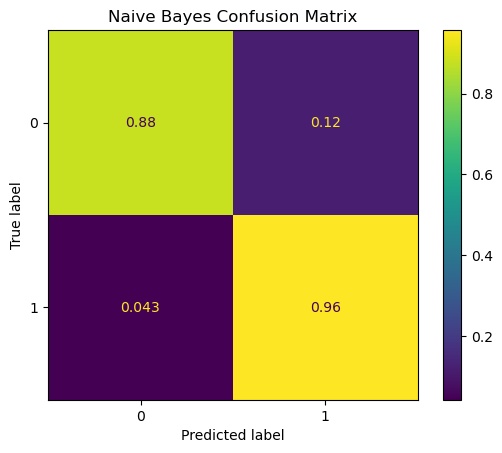

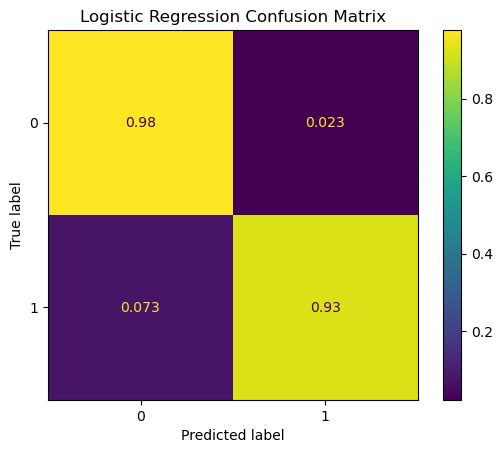

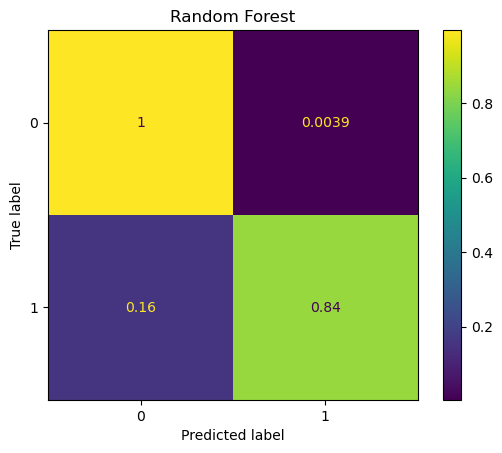

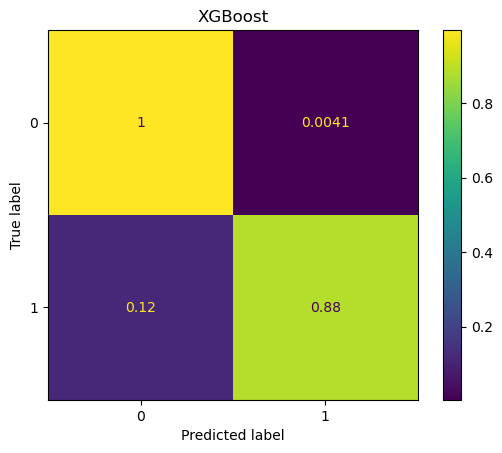

In [339]:
ConfusionMatrixDisplay.from_predictions(y_cv, y_pred_custom, normalize='true')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_cv, y_pred_lr, normalize='true')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_cv, y_pred_rf, normalize='true')
plt.title("Random Forest")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_cv, y_pred_xgb, normalize='true')
plt.title("XGBoost")
plt.show()